In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import pickle
import dill as pickle

In [2]:
class Layer:
    def __init__(self):
        self.x = None
        self.y = None
    
    def forward(self, x):
        pass

    def backward(self, gradient, lr):
        pass

In [3]:
class LinearLayer(Layer):
    
    def __init__(self, x_size, y_size):
        self.weights = np.random.rand(y_size, x_size)
        self.bias = np.random.rand(y_size, 1)
    
    def forward(self, x):
        self.x = x
        return np.dot(self.weights, self.x) + self.bias
    
    def backward(self, x, gradient, lr=0.01):
        weights_grad = np.dot(gradient, self.x.T)
        x_grad = np.dot(self.weights.T, gradient)
        print(self.weights.shape)
        print(weights_grad.shape)
        self.weights -= lr * weights_grad
        self.bias -= lr * gradient
        return x_grad
    
        

In [4]:
class SigmoidActivation(Layer):
    def __init__(self):
        self.sigmoid = lambda x : 1. / (1. + np.exp(-x))
        self.sigmoid_grad = lambda x : self.sigmoid(x) * (1 - self.sigmoid(x))
    
    def forward(self, x):
        self.x = x
        return self.sigmoid(self.x)
    
    def backward(self, gradient, lr=0.01):
        return np.multiply(gradient,self.sigmoid_grad(self.x))
    

In [5]:
class TanhActivation(Layer):
    def __init__(self):
        self.tanh = lambda x : np.tanh(x)
        self.tanh_grad = lambda x : 1 - np.tanh(x)**2
    
    def forward(self, x):
        self.x = x
        return self.tanh(self.x)
    
    def backward(self, gradient, lr=0.01):
        return np.multiply(gradient,self.tanh_grad(self.x))
    

In [6]:
class CrossEntropyLoss:
    
    def cross_entropy(self, y_actual, y_pred):
        return np.mean(-y_actual * np.log(y_pred)- (1-y_actual) * np.log(1 - y_pred))
    
    def cross_entropy_grad(self, y_actual, y_pred):
        return ((1 - y_actual) / (1 - y_pred) - y_actual / y_pred) / np.size(y_actual)
    
    def forward(self, y_actual, y_pred):
        self.y = y_pred
        return self.cross_entropy(y_actual, y_pred)
    
    def backward(self, y_actual, y_pred):
        return self.cross_entropy_grad(y_actual, y_pred)

In [7]:
class Sequential(Layer):
    def __init__(self, network=[]):
        self.network = network
        
    def forward(self, x):
        out = x
        for layer in self.network:
            out = layer.forward(out)
        return out

    def backward(self, gradient, lr = 0.01):
        grad = gradient
        for layer in reversed(self.network):
            grad = layer.backward(grad, lr)
        return grad
    
        

In [8]:

def train(sequential_network, x_train, y_train, epochs = 2000, lr =0.01):
    loss_list =[]
    for itr in range(epochs):
        error = 0
        for x, y_actual in zip(x_train, y_train):
            y_pred = sequential_network.forward(x)
            #print('y---pred',y_pred)
            loss = CrossEntropyLoss()
            error+= loss.cross_entropy(y_actual, y_pred)
            #print('error: ',error)
            gradient_loss = loss.cross_entropy_grad(y_actual, y_pred)
            sequential_network.backward(gradient_loss,lr=0.01)
        error /= len(x_train)
        loss_list.append(error)
        #print(f"{itr + 1}/{epochs}, error={error}")
    fig = plt.figure()
    ax = fig.add_subplot(211)
    ax.plot(np.arange(0,epochs),loss_list)
    ax.set_title('Training Loss')
    return sequential_network

def predict(model, x_test):
    return model.forward(x_test)

def save(model, filename):
    pickle.dump(model,open(filename, 'wb'))

def load(filename):
    return pickle.load(open(filename, 'rb'))

(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)

(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)

(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)

(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)

(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)

(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)

(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)

(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)

(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)

(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)

(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)

(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)

(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)

(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)

(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)

(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)

(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)

(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(1, 2)

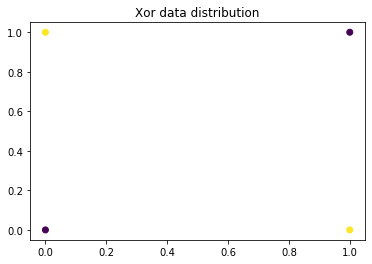

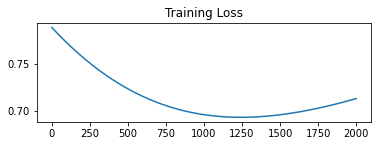

In [9]:
# Define XOR inputs -- prepend a constant of 1 for bias multiplication
samples = np.reshape([[0, 0],
                    [0, 1],
                    [1, 0],
                    [1, 1]],(4,2,1))
targets = np.reshape([[0], [1], [1], [0]],(4,1,1))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(samples[:, 0], samples[:, 1], c=targets)
ax.set_title('Xor data distribution')

model = Sequential([
    LinearLayer(2,2),
    SigmoidActivation(),
    LinearLayer(2,1),
    SigmoidActivation() ])

trained_model = train(model,samples,targets)
filename = 'XOR_solved.w'
save(trained_model,filename)
mp = load(filename)

In [10]:
predict(trained_model,samples[3])

array([[0.39858411]])

In [11]:
predict(mp,samples[3])

array([[0.39858411]])

# Hand Written Digit Recognition

In [12]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [18]:
mnist_samples, mnist_targets = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

In [19]:
# Normalization
mnist_samples = mnist_samples / 255.
#convery to numbers
mnist_targets_dup = [int(x) for x in mnist_targets]
mnist_targets_dup = np.array(mnist_targets_dup)

In [20]:
train_split,test_split,train_y_split,test_y_split = train_test_split(mnist_samples, mnist_targets_dup,test_size=0.1, random_state=123)

In [21]:
train_split.shape
train_y_split

array([0, 9, 2, ..., 4, 0, 9])

In [22]:
mnist_model_1 = model = Sequential([
    LinearLayer(28*28,40),
    SigmoidActivation(),
    LinearLayer(40,10),
    SigmoidActivation() ])

trained_model = train(mnist_model_1,train_split,train_y_split)

(10, 40)
(40, 40)


ValueError: operands could not be broadcast together with shapes (10,40) (40,40) (10,40) 

In [ ]:
predict(trained_model,test_split)